In [1]:
!pip install torch torchvision tqdm
!pip install easyfsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 2.9 MB/s eta 0:00:00


In [2]:
import os
import torchvision
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import transforms
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from easyfsl.utils import plot_images, sliding_average
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import mobilenet_v2 , resnet50
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder,DatasetFolder,VisionDataset
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from torchvision.io import read_image
from torch.utils.data import random_split
import torch.optim as optim
import unittest
import torch.nn.init as init
from torch.autograd import Variable
import math
from torch.nn.functional import softmax, cross_entropy
from PIL import Image
import csv

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [3]:
image_size = 224

In [4]:
base_path = "/kaggle/input/autistic-children-facial-data-set"

train_path = base_path + "/train"
test_path = base_path + "/test"
valid_path = base_path + "/valid"

In [5]:
train_set = ImageFolder(
    root=train_path,
    transform= transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]),
)

In [6]:
test_set = ImageFolder(
    root=test_path,
    transform=transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
]),
)

In [7]:
valid_set = ImageFolder(
    root=valid_path,
    transform=transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
]),
)

In [8]:
N_WAY = 2  # no. of classes: autistic and non autistic
N_SHOT = 4  # no. of images per class
N_QUERY = 10  #  query set
N_EVALUATION_TASKS = 1000

In [9]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:

        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        
        z_support = F.normalize(z_support, p=2, dim=-1)
        z_query = F.normalize(z_query, p=2, dim=-1)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # Transform distances into classification scores
        scores = -dists
        return scores

# Load the MobileNetV2 model with modifications

num_classes = 2  # Change this as per your requirement
convolutional_network = mobilenet_v2(pretrained=True)
convolutional_network.classifier[1] = nn.Linear(convolutional_network.last_channel, 128)
convolutional_network.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

# Modify the classifier to match the dense layers described in the architecture
convolutional_network.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(convolutional_network.last_channel, 128),  
    nn.ReLU(),  
    nn.Linear(128, 2)  
)

model = PrototypicalNetworks(convolutional_network).cuda()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 63.1MB/s]


In [10]:
print(model)

PrototypicalNetworks(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kern

In [11]:
N_WAY = 2  # no. of classes: autistic and non autistic
N_SHOT = 4  # no. of images per class
N_QUERY = 10  #  query set
N_EVALUATION_TASKS = 1000

In [12]:
#print(test_set.samples)

def get_labels_function():
    return [label for _, label in test_set.samples]

test_set.get_labels = get_labels_function
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

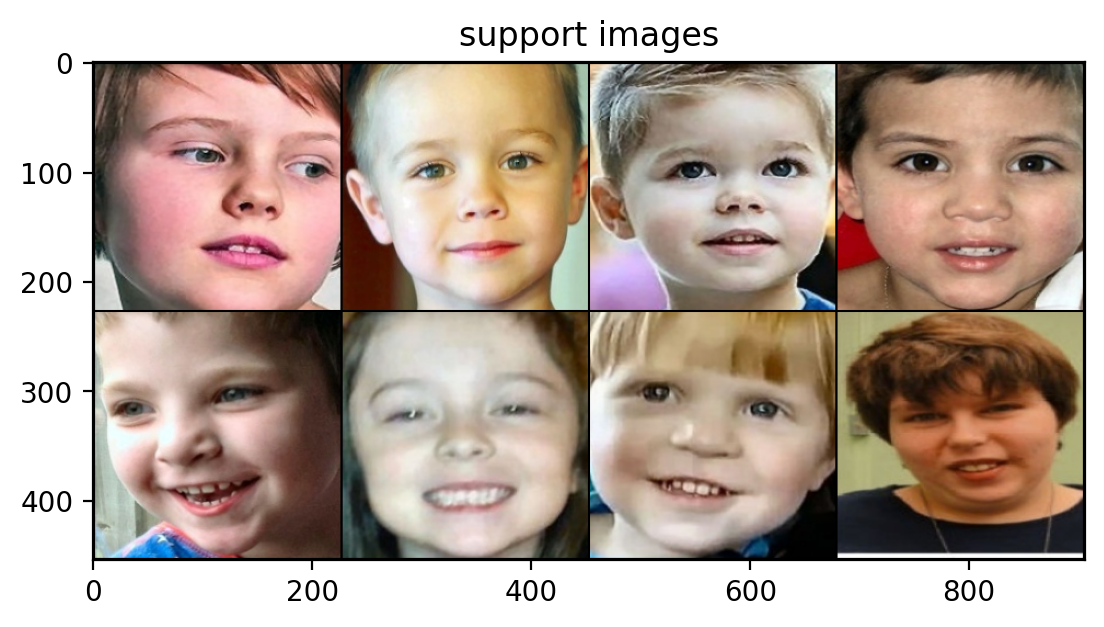

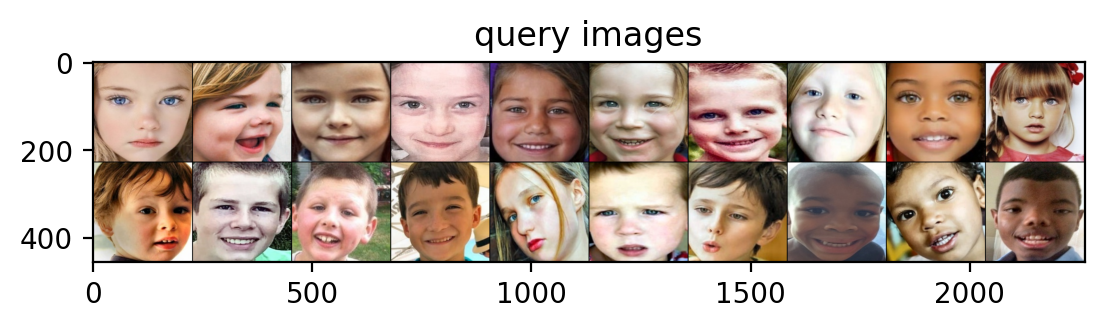

In [13]:
(   example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [14]:
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)



def val_fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    optimizer.step()

    return loss.item()

In [16]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.samples[example_class_ids[example_query_labels[i]]]} / {test_set.samples[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0) / ('/kaggle/input/autistic-children-facial-data-set/test/autistic/001.jpg', 0)
('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0) / ('/kaggle/input/autistic-children-facial-data-set/test/autistic/001.jpg', 0)
('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0) / ('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0)
('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0) / ('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0)
('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0) / ('/kaggle/input/autistic-children-facial-data-set/test/autistic/001.jpg', 0)
('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0) / ('/kaggle/input/autistic-children-facial-data-set/test/autistic/002.jpg', 0)
('/kaggle/input/autistic-children-facia

In [17]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)

In [18]:
def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):
            
            loss_value = val_fit(support_images, support_labels, query_images, query_labels)
            validation_losses.append(loss_value)

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )
            
            validation_accuracies.append((100 * correct/total))

            total_predictions += total
            correct_predictions += correct
            

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

In [19]:
#evaluate(test_loader)

In [20]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 1000

# Training set
train_set.get_labels = lambda: [instance[1] for instance in train_set.samples]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Validation set
valid_set.get_labels = lambda: [instance[1] for instance in valid_set.samples]
validation_sampler = TaskSampler(
    valid_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)
validation_loader = DataLoader(
    valid_set,
    batch_sampler=validation_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=validation_sampler.episodic_collate_fn,
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [22]:
log_update_frequency = 10

model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        training_losses.append(loss_value)
        correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )
        training_accuracies.append((100 * correct/total))
        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(training_losses, log_update_frequency))

100%|██████████| 40000/40000 [1:40:26<00:00,  6.64it/s, loss=0.161]


In [23]:
evaluate(test_loader)

100%|██████████| 1000/1000 [01:04<00:00, 15.55it/s]

Model tested on 1000 tasks. Accuracy: 89.45%


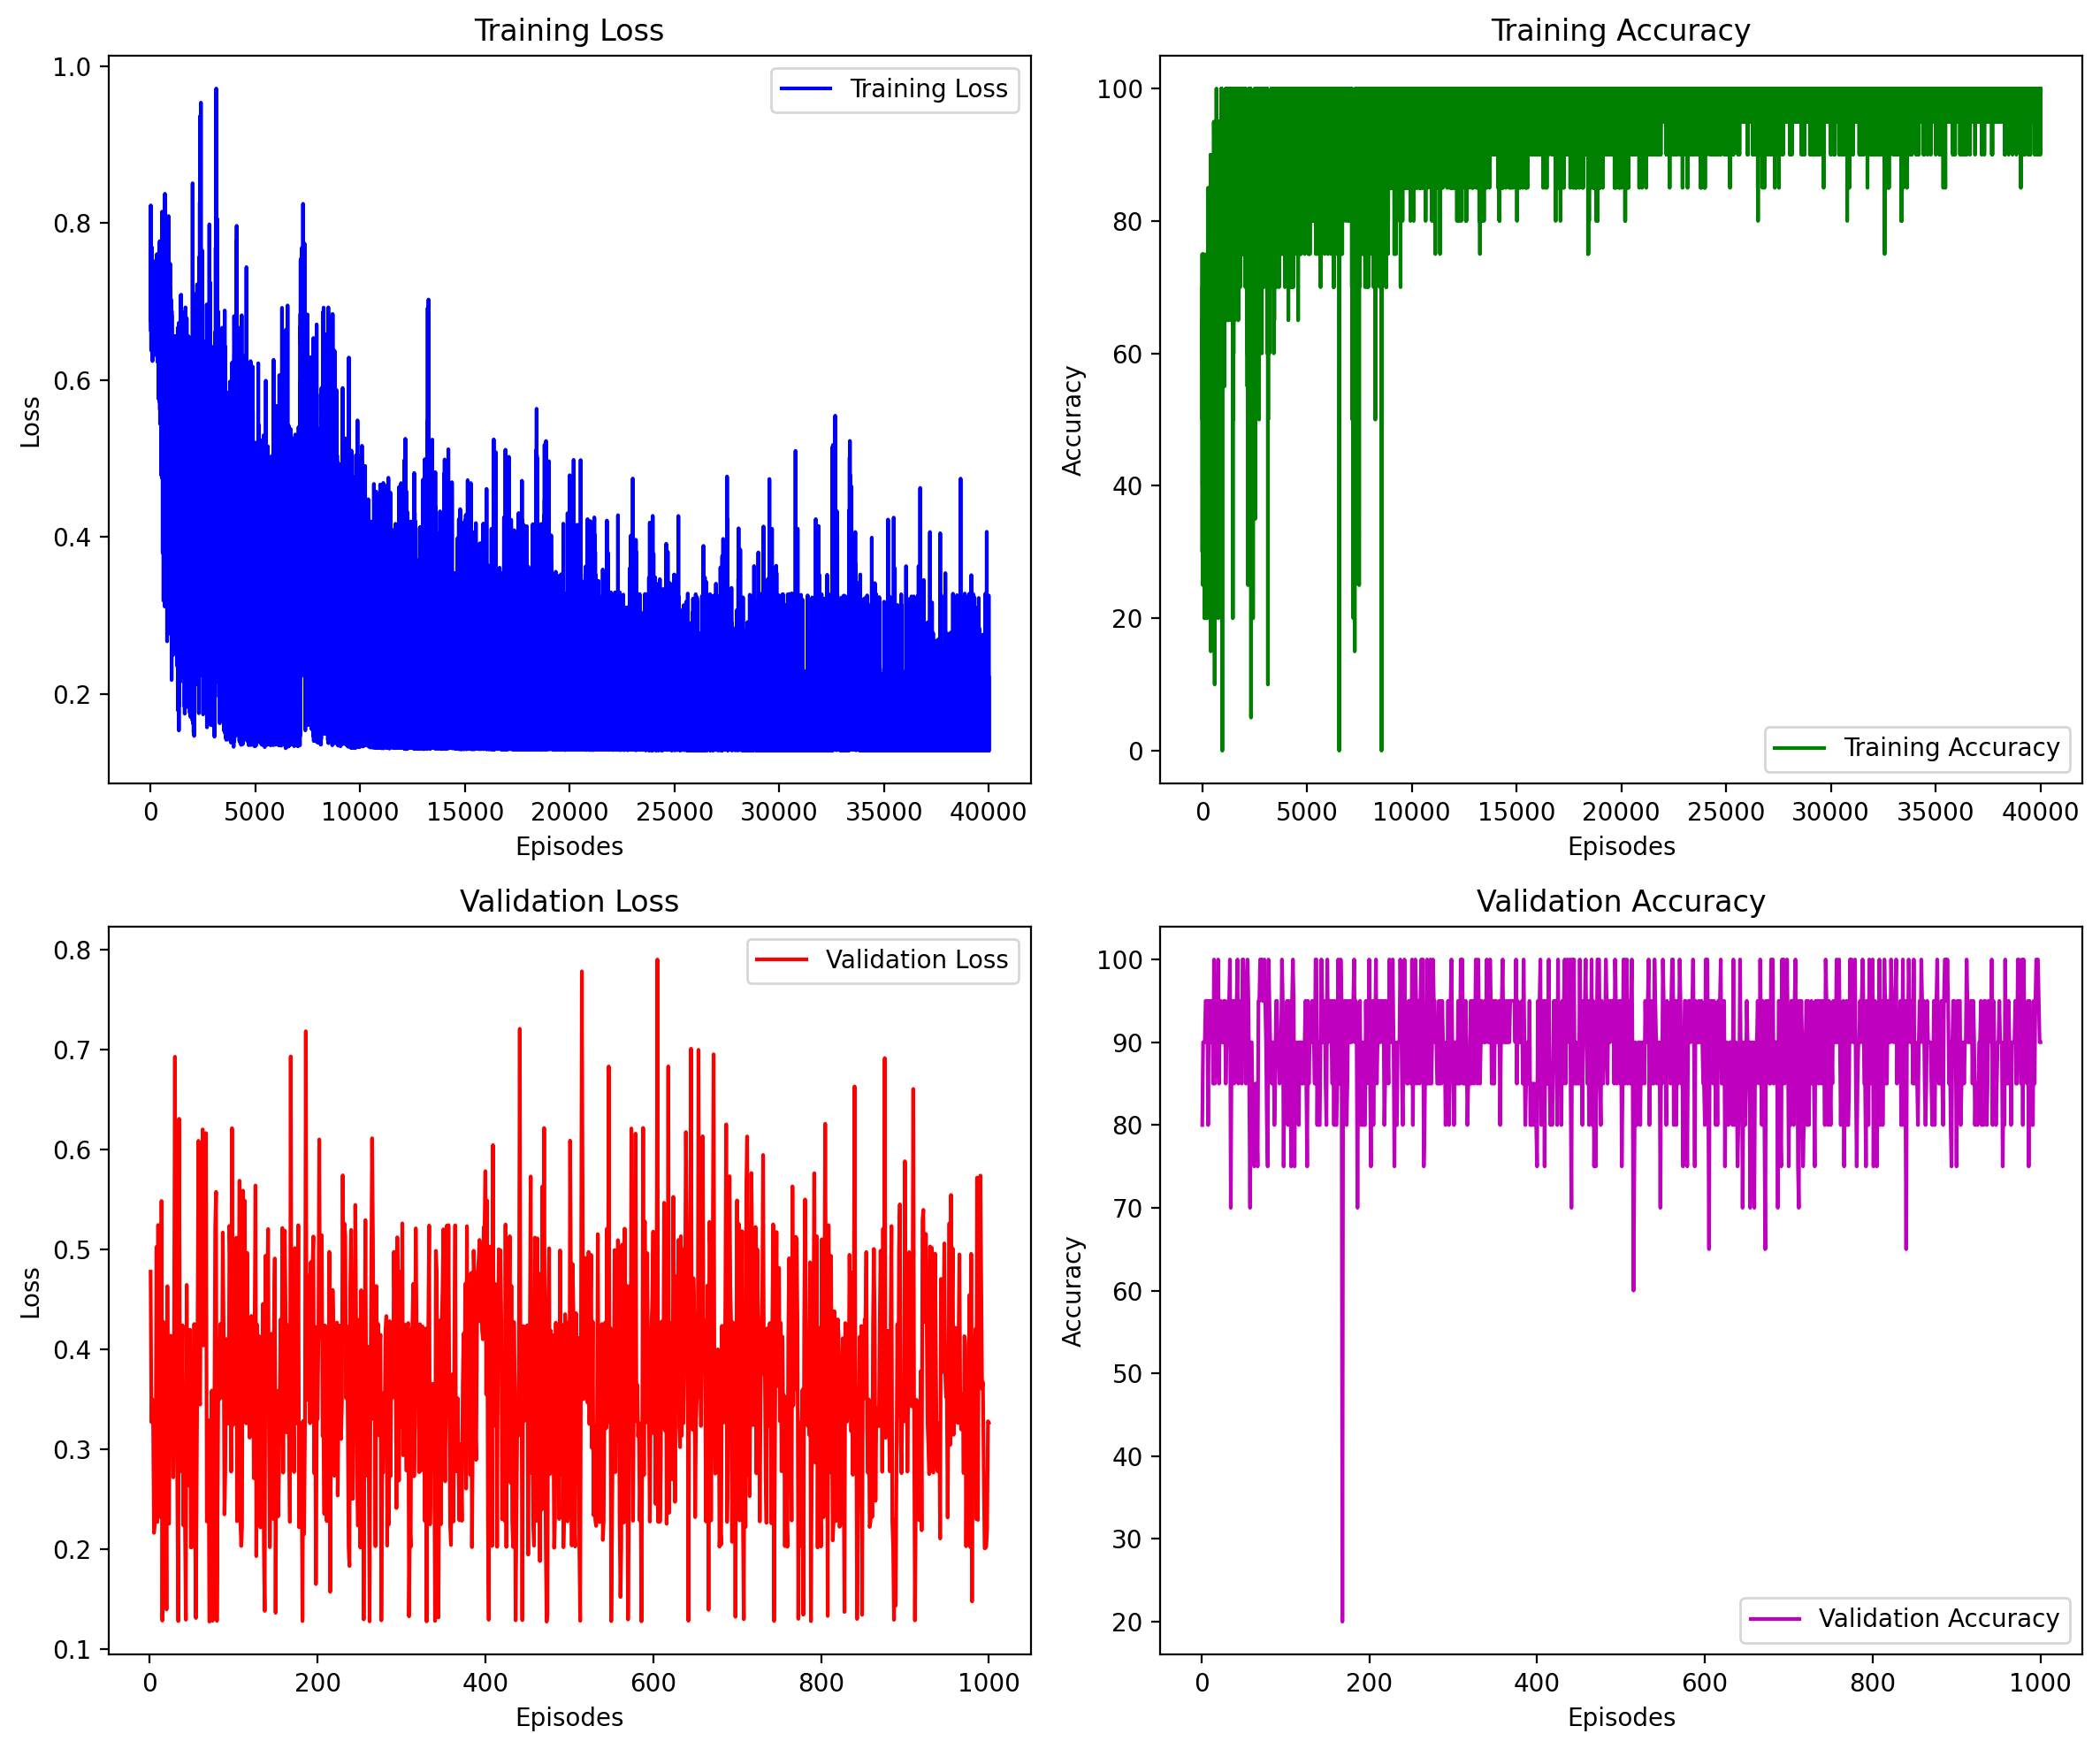

In [24]:
tasks = range(1, N_TRAINING_EPISODES + 1)
val_tasks = range(1, N_EVALUATION_TASKS + 1)

plt.figure(figsize=(12, 10))

# Plot Training Loss
plt.subplot(2, 2, 1)
plt.plot(tasks, training_losses, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(tasks, training_accuracies, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Episodes')
plt.ylabel('Accuracy')
plt.legend()

# Plot Validation Loss
plt.subplot(2, 2, 3)
plt.plot(val_tasks, validation_losses, 'r', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(val_tasks, validation_accuracies, 'm', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Episodes')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


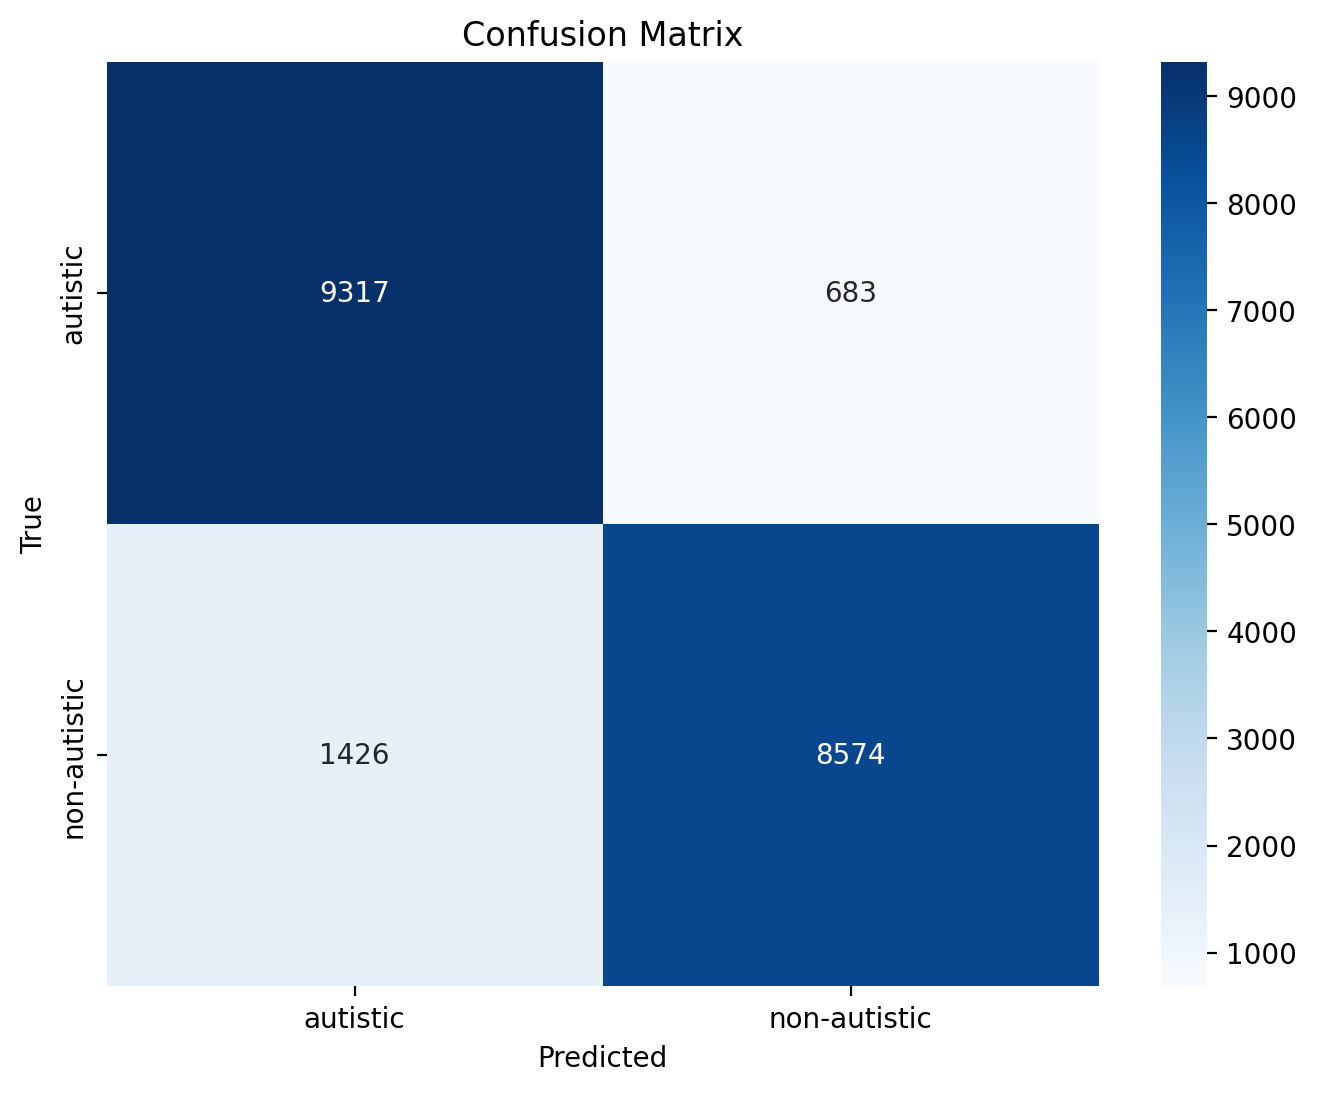

In [26]:
y_true = []
y_pred = []
class_labels = ['autistic', 'non-autistic']

model.eval()
with torch.no_grad():
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm(enumerate(test_loader), total=len(test_loader)):
        _, predicted_labels = torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)
        y_true.extend(query_labels.numpy())
        y_pred.extend(predicted_labels.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, class_labels)
